In [1]:
# I do not take credit for the functions in which sample size, MDL, or p-score + z-score are calculated. 
# I found them online and made tweaks to fit my needs.
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms

In [2]:
# data source: https://www.kaggle.com/zhangluyuan/ab-testing
data = pd.read_csv('./ab_data.csv')

# Section 1: Define Sample Size and Minimum Detectable Lift
### This would typically be done before launching the test, but this is a portfolio piece with a pre-defined dataset. I will explain how I would go about calculating Sample and MDL in an actual work environment below. Additionally, I typically do these calculations in R, but I will do them in Python for the sake of this project.

In [23]:
# for the function below, I would look at historical data and define a baseline conversion rate, as well as
# a forecast for unique visitors. I would then plug in an expected MDL and play around until the numbers 'worked'.
# significance (p-value) of 0.05 is standard and would equate to '95% confident in the results'.
# power of 0.8 is standard as well. Power is used to avoid Type II error.

def compute_sample_size(baselineConversionRate, MDL, pvalue = 0.05, power = 0.8):
    prop2 = baselineConversionRate + MDL
    effect_size = sms.proportion_effectsize(baselineConversionRate, prop2)
    sample_size = sms.NormalIndPower().solve_power(
        effect_size, power = power, alpha = pvalue, ratio = 1)
    
    return sample_size

sample_size = compute_sample_size(baselineConversionRate = 0.123, MDL = 0.03)
print('sample size required per group: ', int(round(sample_size)))

sample size required per group:  2069


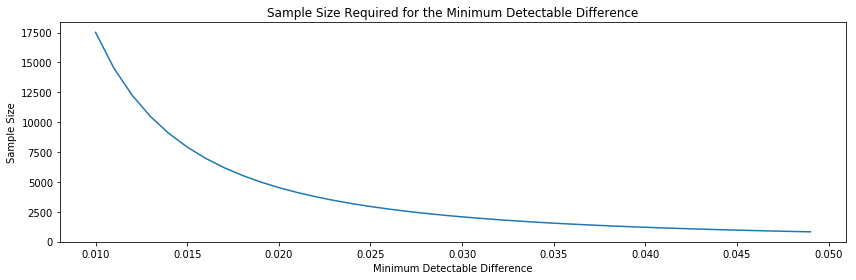

In [25]:
# this visualizes the relationship between sample size and MDL. They have have an inverse relationship - as MDL
# increases, sample decreases. As MDL decreases, sample increases. As an analyst, my job is to figure out
# the optimal sample to MDL to get statistically significant results.

# how to read the chart below would be if we were to see a 0.025 MDL (+2.5% test vs. control), we would need ~3k 
# unique visitors per sample to achieve a p-value of 0.05, or 95% confidence.
sample_sizes = []
MDL = np.arange(0.01, 0.05, 0.001)
for i in MDL:
    sample_size = compute_sample_size(baselineConversionRate = 0.123, MDL = i)
    sample_sizes.append(sample_size)

plt.plot(MDL, sample_sizes)
plt.title('Sample Size Required for the Minimum Detectable Difference')
plt.ylabel('Sample Size')
plt.xlabel('Minimum Detectable Difference')
plt.tight_layout()
plt.show()

# Section 2: Data Exploration and Validation

In [4]:
data.head(1)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0


In [5]:
# correct datatype and create columns for day and hour. will make analysis easier later on.
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['day'] = pd.to_datetime(data['timestamp']).apply(lambda x: x.date())
data['hour'] = data['timestamp'].dt.hour

In [6]:
# confirm user_id was only in the treatment or control group. 
control = data[data['group'].str.contains('control')]
treatment = data[data['group'].str.contains('treatment')]
len(pd.merge(control, treatment, on='user_id', how='inner'))

# should not be exposed to both. remove overlap.
exclusions = pd.merge(control, treatment, on='user_id', how='inner')
exclusions = exclusions['user_id'].tolist()
data = data[~data['user_id'].isin(exclusions)]

In [7]:
# validate test size
data.groupby('group')['user_id'].nunique()

group
control      144300
treatment    144389
Name: user_id, dtype: int64

In [8]:
# confirm that frequency is consistent across both groups.
print('Control Frequency: ', data[data['group']=='control']['user_id'].count() / 
      data[data['group']=='control']['user_id'].nunique())
print('Test Frequency: ', data[data['group']=='treatment']['user_id'].count() / 
      data[data['group']=='treatment']['user_id'].nunique())

Control Frequency:  1.006978516978517
Test Frequency:  1.00687032945723


In [9]:
# check that the test started and ended on the same day for test and control
print('Start date for Test group: ', data[data['group']=='treatment']['timestamp'].min())
print('Start date for Control group: ', data[data['group']=='control']['timestamp'].min())
print('End date for Test group: ', data[data['group']=='treatment']['timestamp'].max())
print('End date for Control group: ', data[data['group']=='control']['timestamp'].max())

Start date for Test group:  2017-01-02 13:42:05.378582
Start date for Control group:  2017-01-02 13:42:15.234051
End date for Test group:  2017-01-24 13:41:44.097174
End date for Control group:  2017-01-24 13:41:54.460509


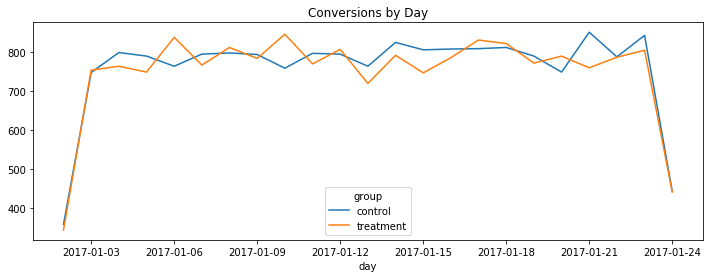

In [10]:
# visualize conversions by day. 
# large dropoffs on start and end dates due to incomplete days.
# nothing too noteable at a day level.
plt.rcParams['figure.figsize'] = 12,4
data.groupby(['day','group'])['converted'].sum().unstack().plot()
plt.title('Conversions by Day')
plt.show()

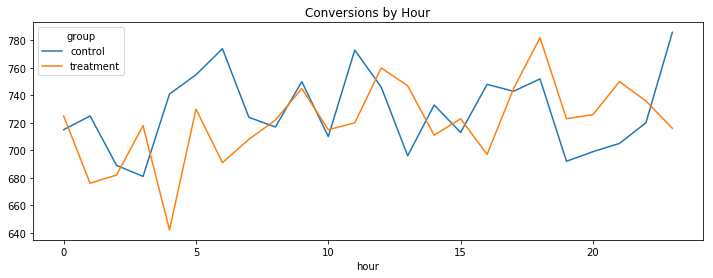

In [11]:
# visualize conversions by hour of day. 
# nothing noteable by the hour either.
data.groupby(['hour','group'])['converted'].sum().unstack().plot()
plt.title('Conversions by Hour')
plt.show()

# Section 3: Analysis

In [12]:
def two_proportions_test(controlConversions, controlSampleSize, testConversions, testSampleSize):
    prop_a = controlConversions / controlSampleSize
    prop_b = testConversions / controlSampleSize
    prop_pooled = (controlConversions + testConversions) / (controlSampleSize + testSampleSize)
    var = prop_pooled * (1 - prop_pooled) * (1 / controlSampleSize + 1 / testSampleSize)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [13]:
controlCount = data[data['group']=='control']['user_id'].nunique()
controlConvertCount = data[data['group']=='control']['converted'].sum()
testCount = data[data['group']=='treatment']['user_id'].nunique()
testConvertCount = data[data['group']=='treatment']['converted'].sum()

In [14]:
zscore, pvalue = two_proportions_test(controlConvertCount, controlCount, testConvertCount, testCount)
print('z-score = {:.2f}, p-value = {:.2f}'.format(zscore, pvalue))

z-score = 1.13, p-value = 0.26
